In [ ]:
import os
!pip install fasttext
import fasttext
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET

In [ ]:
if not os.path.exists("cc.en.300.bin"):
  !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
  !gzip -d cc.en.300.bin.gz

In [ ]:
if not os.path.exists("articles/"):
  !wget https://zenodo.org/record/1239675/files/articles.zip?download=1 -O articles.zip
  !unzip articles.zip
  !rm articles.zip
  print("Data successfully downloaded")
else:
  print("Data already downloaded")

In [ ]:
model = fasttext.load_model('cc.en.300.bin')

In [ ]:
#Utilizo las funciones que fueron brindados en el buzzfeed de clasificacion.

In [5]:
def read_data(test_size=0.2,random_state=0):
  data = {
      # "author": [],
      # "title": [],
      "mainText": [],
      "orientation": [],
      # "veracity": []
  }
  index = []
  for filename in os.listdir("articles/"):
    root = ET.parse(f"articles/{filename}").getroot()
    index.append(int(filename.split(".")[0]))
    for elem in root:
      if elem.tag in data.keys():
        data[elem.tag].append(elem.text)
  data = pd.DataFrame(data,index=index)
  data = data[data.notna().all(axis="columns")]
  data = data.sample(frac=1,random_state=random_state)
  N = len(data)
  train_split, test_split = data.iloc[int(N*test_size):,:], data.iloc[:int(N*test_size),:]
  train_split = train_split.reset_index(drop=True)
  test_split = test_split.reset_index(drop=True)
  return train_split, test_split
random_seed = 176249  


In [6]:
def normalize_text(corpus,stop_words=None):

  # Convierto a lowercase
  corpus_lower = corpus.str.lower()

  # Elimino signos de puntuación, caracteres raros, etc.
  normalized_corpus = corpus_lower.str.replace(r"[^\w\d\s]+","",regex=True)

  # Elimino los stopwords
  if stop_words is not None:
    stop_words = "|".join(stop_words)
    normalized_corpus = normalized_corpus.str.replace(stop_words,"",regex=True)

  # Elimino espacios innecesarios
  normalized_corpus = normalized_corpus.str.replace(r"\s+"," ",regex=True)

  return normalized_corpus

In [ ]:
import nltk
nltk.download('punkt')

In [8]:
from nltk import word_tokenize
from collections import defaultdict
from tqdm import tqdm


def create_vocabulary(corpus,tokenizer,max_tokens=40000,min_freq=1):
  counts = defaultdict(lambda: 0)
  for comment in tqdm(corpus):
    for token in tokenizer(comment):
      counts[token] += 1

  valid_tokens = sorted([tk for tk in counts.keys() if counts[tk] >= min_freq],key=counts.get,reverse=True)[:max_tokens]
  counts = [counts[tk] for tk in valid_tokens]
  return pd.Series(counts,index=valid_tokens)

100%|██████████| 1284/1284 [00:02<00:00, 614.64it/s]


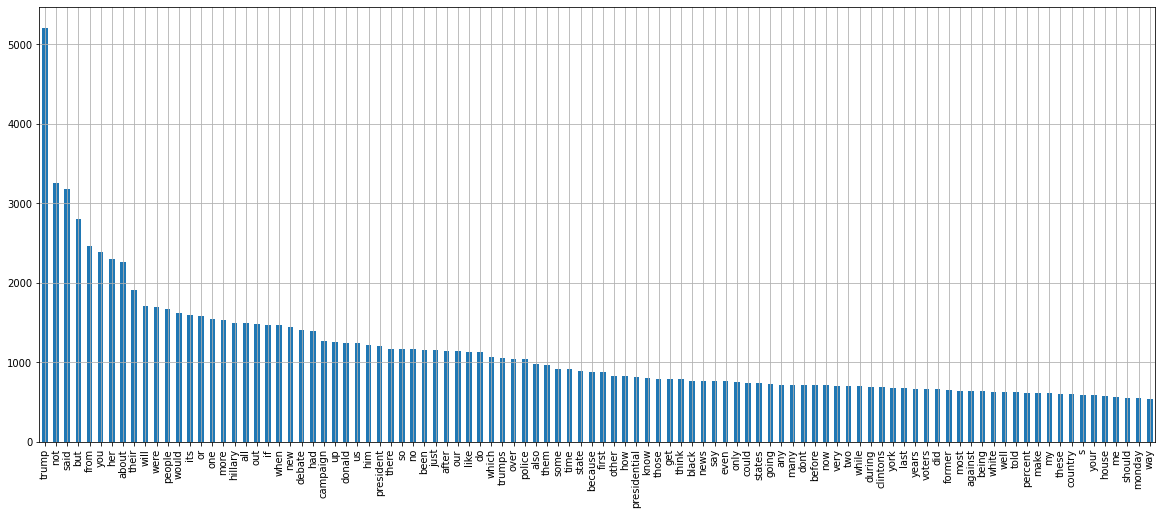

In [63]:
#los stop words lo fui sacando palabras a medida que veia cuales no aportaban mucha informacion
stop_words= ["the ","to ","and ","of ","a ","in ","that","for ","on ","this","at ","on ", "is ", "it ", "he ", "was ", "with ", "as ", "iâll ", "be ", "are ", "i ", "they ", "we ", "an ", "by ", "have ", "who "]
train_split, test_split = read_data(test_size=0.2,random_state=random_seed)
train_split["mainText"] = normalize_text(train_split["mainText"],stop_words=stop_words)
words_to_be_plotted = create_vocabulary(train_split["mainText"], word_tokenize,max_tokens=10000,min_freq=5)
fig, ax = plt.subplots(1,1,figsize=(20,8))
words_to_be_plotted[:100].plot(kind="bar",ax=ax,fontsize=10)
ax.grid(True)
words_to_be_plotted = pd.Series.to_string(words_to_be_plotted)
words_to_be_plotted  = words_to_be_plotted.split('\n')

large = len(words_to_be_plotted)

for x in np.arange(large):
  words_to_be_plotted[x] = ''.join([i for i in words_to_be_plotted[x] if not i.isdigit()])
  words_to_be_plotted[x] = words_to_be_plotted[x].strip() 



In [56]:
list_of_words = np.array([])
largo = np.size(words_to_be_plotted)
for x in np.arange(largo):
  if(len(words_to_be_plotted[x])> 5):
    list_of_words = np.append(list_of_words, words_to_be_plotted[x])
list_of_words = list_of_words[40:60]

In [67]:
list_of_words2 = ['people', 'debate', 'campaign', 'president', 'presidential', 'news', 'states', 'voters']

In [72]:
list_of_words3 = ['black','white', 'states', 'country', 'black', 'white', 'him', 'her', 'think', 'say', 'while', 'during']

In [57]:
word_embeddings_matrix = np.vstack([model[word] for word in list_of_words])
print("Matrix shape:",word_embeddings_matrix.shape)

Matrix shape: (20, 300)


In [71]:
from sklearn import decomposition

def plot_words2d(word_embeddings_matrix,words_to_be_plotted,x_lim=None,y_lim=None):
  """
  Función para graficar los vectores en dos dimensiones.

  Args:
    - word_embeddings_matrix: numpy.array de dimensión (n x d) con las
    representaciones de las palabras. (n = cantidad de palabras, d = dimensión
    de los vectores.)
    - words_to_be_plotted: lista de palabras correspondientes a las filas de la 
    matriz word_embeddings_matrix.
    - x_lim: tupla (float, float) con los límites del gráfico en la direción del 
    eje x.
    - y_lim: tupla (float, float) con los límites del gráfico en la direción del 
    eje y.

  """

  # Extraigo las primeras 2 componentes principales
  pca = decomposition.PCA(n_components=2)
  pca.fit(word_embeddings_matrix)
  principals = pca.transform(word_embeddings_matrix)

  # Si los límites son None, los seteo para inluir a todas las representaciones.
  if not x_lim:
    x_lim = (principals[:,0].min()*1.1, principals[:,0].max()*1.1)
  if not y_lim:
    y_lim = (principals[:,1].min()*1.1, principals[:,1].max()*1.1)

  # Grafico los puntos
  fig, ax = plt.subplots(1,1,figsize=(12,12))
  ax.plot(principals[:,0],principals[:,1],"o",ms=3)

  # Anoto las palabras
  for i, word in enumerate(words_to_be_plotted):
    if principals[i,0] <= x_lim[0] or principals[i,1] <= y_lim[0] or \
      principals[i,0] >= x_lim[1] or principals[i,1] >= y_lim[1]:
        continue
    ax.text(principals[i,0]*1.001,principals[i,1]*1.001,word,fontsize=15)

  ax.grid(True)
  ax.set_xlim(*x_lim)
  ax.set_ylim(*y_lim)
  fig.tight_layout()


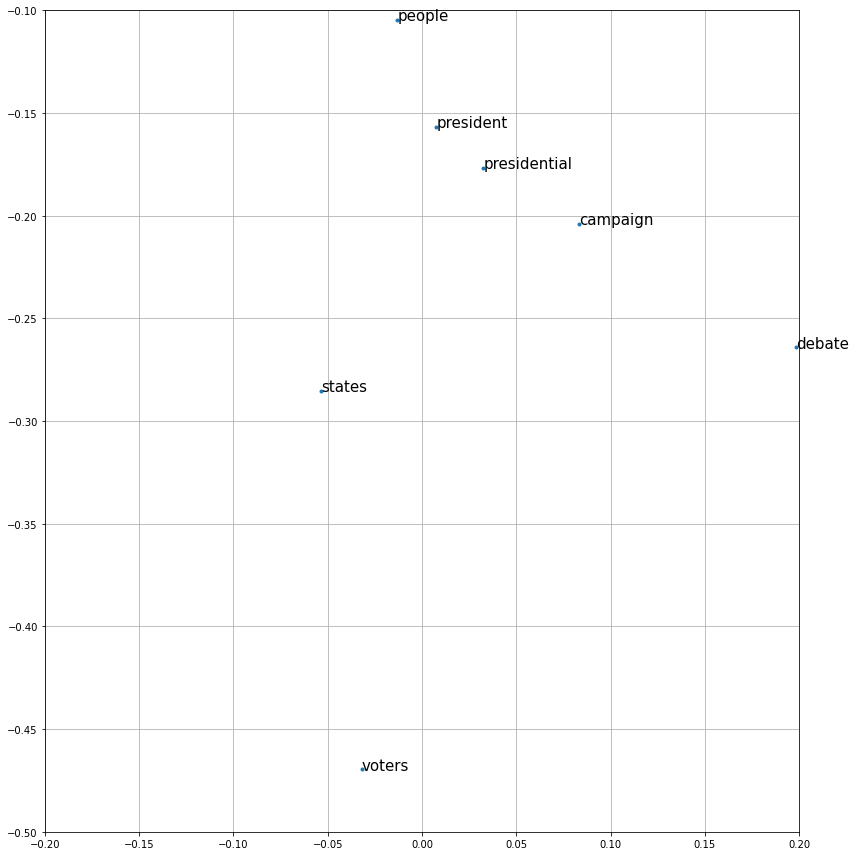

In [82]:
#ploteo palabras de la segunda lista en la que estan palabras realcionadas con las elecciones
word_embeddings_matrix2 = np.vstack([model[word] for word in list_of_words2])
x_lim = (-0.2,0.2)
y_lim = (-0.5,-0.1)
plot_words2d(word_embeddings_matrix2,list_of_words2,x_lim,y_lim)

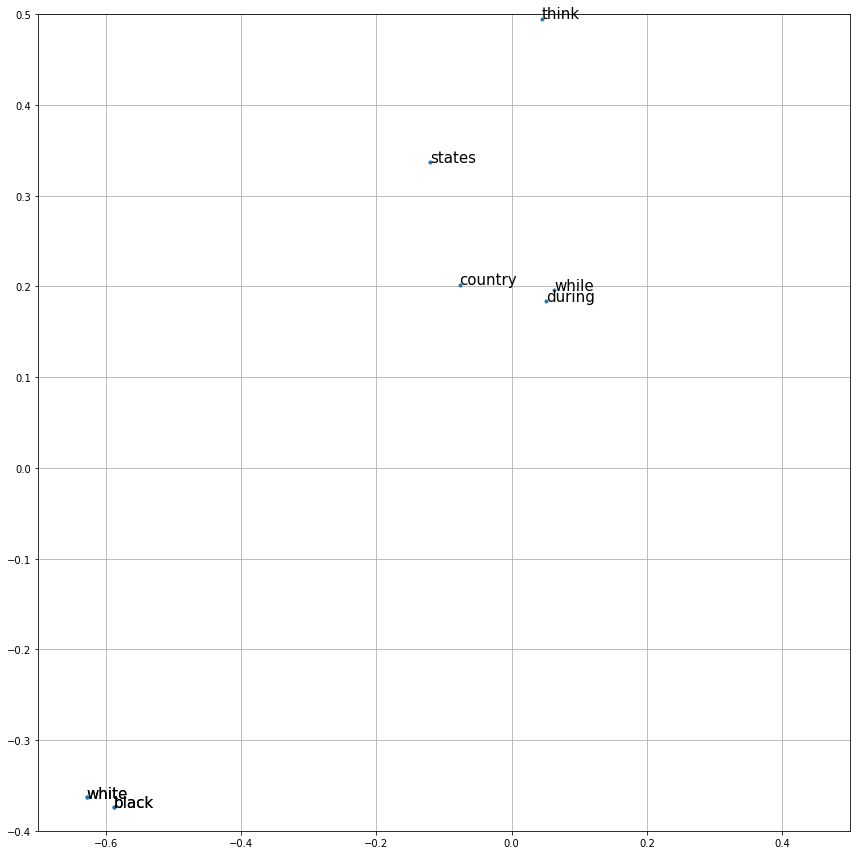

In [84]:
word_embeddings_matrix3 = np.vstack([model[word] for word in list_of_words3])
x_lim = (-0.7,0.5)
y_lim = (-0.4,0.5)
plot_words2d(word_embeddings_matrix3,list_of_words3,x_lim,y_lim)